# Inference in Larger Graphical Models: Student Performance Estimation

## William Koehrsen wjk68

# Introduction

In this notebook, I look at predicting student outcomes from a set of demographic and character indicators formulating the problem as a supervised regression task. I  develop a Bayesian linear regression for estimating final student grades and compare it with several traditional machine learning models. Student grades are influenced by many factors, and using a linear model allows us to determine the relationships between these variables and the final performance. Moreover, Bayesian Linear Regression has several advantages over traditional machine learning methods as we will examine. 

# Problem Statement

This is a supervised regression problem: we have known labels, the final performance of students, that we wish to predict from a set of known features. The labels are continuous (from 1-20) which makes this a regression problem (we could also formulate it as a classification with 20 discrete classes but we will treat the grades as continuous). As a machine learning task, the problem is broken up into two sections: we train the model on a training set of data and then make preditions on a hold-out testing set. During training the model learns a mapping between the features and the labels. In testing, we evaluate how well this model generalizes to new data points. There are numerous standard machine learning approaches for supervised regression, most of which can be quickly built, trained, and evaluated in scikit-learn. We will compare the Bayesian Linear Regression method to several other machine learning approaches. 

## Dataset

The data about student performance was collected from a Portuguese secondary school and is available at the [UCI machine learning repository](http://archive.ics.uci.edu/ml/datasets/Student+Performance). The target variable to predict is `G3`, the final student grade ranging from 1 to 20. There are 30 features (explanatory variables) in the original data, but in order to reduce dimensionality I retain only the most highly correlated features with the response. To carry out feature reduction, I calculate the Pearson Correlation Coefficient between all the features and the response and retain only the features with a absolute magnitude of the correlation coefficient greater than 0.2. Given that we are performing linear regression, selecting variables that are highly linearly correlated with the response should improve the performance of the model by removing noise from irrelevant features. 

### Features (Explanatory Variables)

The final set of five features selected using the cut-off of 0.2 for the absolute magnitude of the correlation coefficient with the response are:

1. `failures`: number of previous class failures, numeric, the feature represents the number of classes if $1 <= n <3$ else the value is 4.
2. `higher_yes`: binary, 0 if the student does not want to pursue higher education and 1 if the student does want to pursue higher education.
3. `Medu`: Mother's education, numeric, 0 = none, 1 = primary education (4th grade), 2 = 5th to 9th grade, 3 = secondary education, 4 = higher education
4. `studytime`: time of studying per week, numeric, 1: <2 hours, 2: 2 to 5 hours, 3: 5 to 10 hours, 4: >10 hours
5. `Dalc`: daily alcohol consumption during the week, numeric, 1 very low to 5 very high

# Bayesian Network

The complete network showing the features and the response is:

<img src="images/bayesian_network_student_performance.png" width="800" height="800" align="center"/>


We have five different variables, all of which affect the final grade to some extent. Instead of specifying prior probabilities for each feature and conditional probabilities between the response (final grade) and the feature, we will use Bayesian Linear Regression to determine the weights for each of the features. This is taking a machine learning approach to the problem, but to use probabilistic programming, we will create a Bayesian Linear Regression model where the final model weights are determined by Markov Chain Monte Carlo methods (in particular the N-UTurns Sampler) rather than choosing the weights which minimize the mean-squared error as in ordinary least-squares regression.

# Bayesian Linear Regression

The standard linear regression model is 

$$ Y = X\beta + \epsilon $$

Where Y is the target, X is the predictor matrix, $\beta$ is the weights vector, and $\epsilon$ is an error term (assumed to be normally distributed). The weights are found using ordinary least squares to minimum the residual sum of squares between the observations (training data) and the fitted model. 

In a Bayesian framework, Linear Regression takes the form

$$ Y \sim \mathcal{N}(X \beta, \sigma^2) $$

Where Y is a random variable with each data point distributed according to a normal distribution. The mean of the normal distribution comes from the data points multiplied by the weights vector $\beta$ with a variance of $\sigma^2$. 

The Bayesian Linear Regression framework has two main advantages:

* Priors: Any previous knowledge about the problem can be quantified by placing prior probabilities on the model parameters. For example, we can assume that the model parameters come from Normal Distributions centered at different values. We can use other distributions such as the Student T-Distribution for the priors of the parameters as well. If we have knowledge about the values of the parameters, we could use these as starting values for the sampling. 
* Uncertainty: Bayesian inference using Markov Chain Monte Carlo does not yield a single estimate for each weight, but rather a posterior _distribution_ from which we can draw conclusions about how likely different values of the weights $\beta$ are in our model. With fewer data points, there will be more uncertainty in $\beta$ and the posterior distributions will be very wide. When we need to make predictions from the model, we can use the entire range of samples to calculate a range of estimates rather than a single value. We can then specify a confidence interval for our estimate in addition to a most likely single value.

# Standard Machine Learning Supervised Regression Models

We will start off by solving this regression problem using several standard machine learning models from scikit-learn. This library makes creating, training, and evaluating models very simple. 

In [14]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

from scipy import stats 

# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16

import seaborn as sns

from IPython.core.pylabtools import figsize

In [2]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error

In [3]:
# PyMC3 for Bayesian Inference
import pymc3 as pm

# Set number of draws for sampling
NDRAWS = 2000

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Read in Data and Examine

We are using data collected from a Portuguese secondary (high) school. The scores used here were recorded in a math class.

In [4]:
# Read in math class scores
math = pd.read_csv('data/student-mat.csv')

# Filter out grades that were 0
math = math[math['G3'] != 0]

math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


We can look at the distribution of the parameter of interest, the final grade using a summary and a histogram.

In [5]:
math['G3'].describe()

count    634.000000
mean      12.187697
std        2.691824
min        1.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: G3, dtype: float64

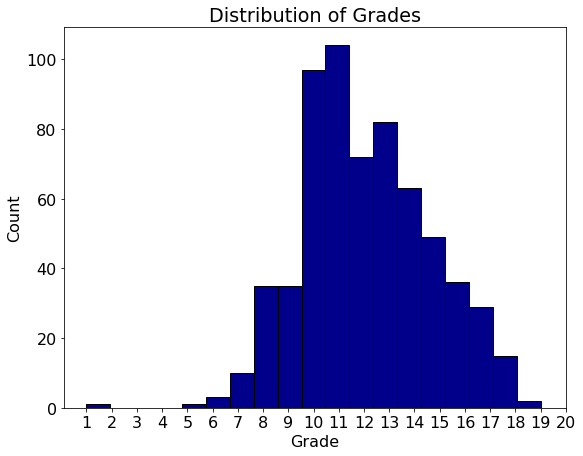

In [9]:
figsize(9, 7)

# Histogram of final grades
plt.hist(math['G3'], edgecolor = 'k', color = 'darkblue', bins = 19)
plt.xlabel('Grade'); plt.ylabel('Count'); plt.title('Distribution of Grades');
plt.xticks(range(1, 21));

## Data Preparation

Data preparation will consist of a few steps:

1. One-hot encoding of categorical variables.
2. Finding the most correlated variables with the response (final grade).
3. Choosing only those variables with an absolute magnitude of the correlation coefficient greater than 0.2.
3. Split the data into training and testing sets for model fitting and evaluation.

In [10]:
def format_data(df):
    # Targets are final grade of student
    labels = df['G3']
    # Drop the school and the grades from features
    df = df.drop(columns=['school', 'G1', 'G2', 'G3'])
    
    # One-Hot Encoding of Categorical Variables
    df = pd.get_dummies(df)
    
    df['y'] = list(labels)
    
    most_correlated = df.corr().abs()['y'].sort_values(ascending=False)
    
    # Keep correlations greater than 0.2 in absolute value
    most_correlated = most_correlated[most_correlated >= 0.2][1:]
    
    df = df.ix[:, most_correlated.index]
    df = df.drop(columns = 'higher_no')
    
    # Split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                        test_size = 0.25,
                                                       random_state=42)
    
    return X_train, X_test, y_train, y_test
    

In [11]:
X_train_math, X_test_math, y_train_math, y_test_math = format_data(math)
X_train_math.head()

,failures,higher_yes,Medu,studytime,Dalc
619,0,1,3,2,1
596,0,1,4,2,1
550,0,1,2,2,2
516,0,1,4,2,2
472,0,1,2,1,1


There are 5 variables in the final dataset representing the features with the greatest correlation with the response. From these five variables, we will try to create a linear regression model that is able to predict student performance. 

## Pairplot of Final Variables

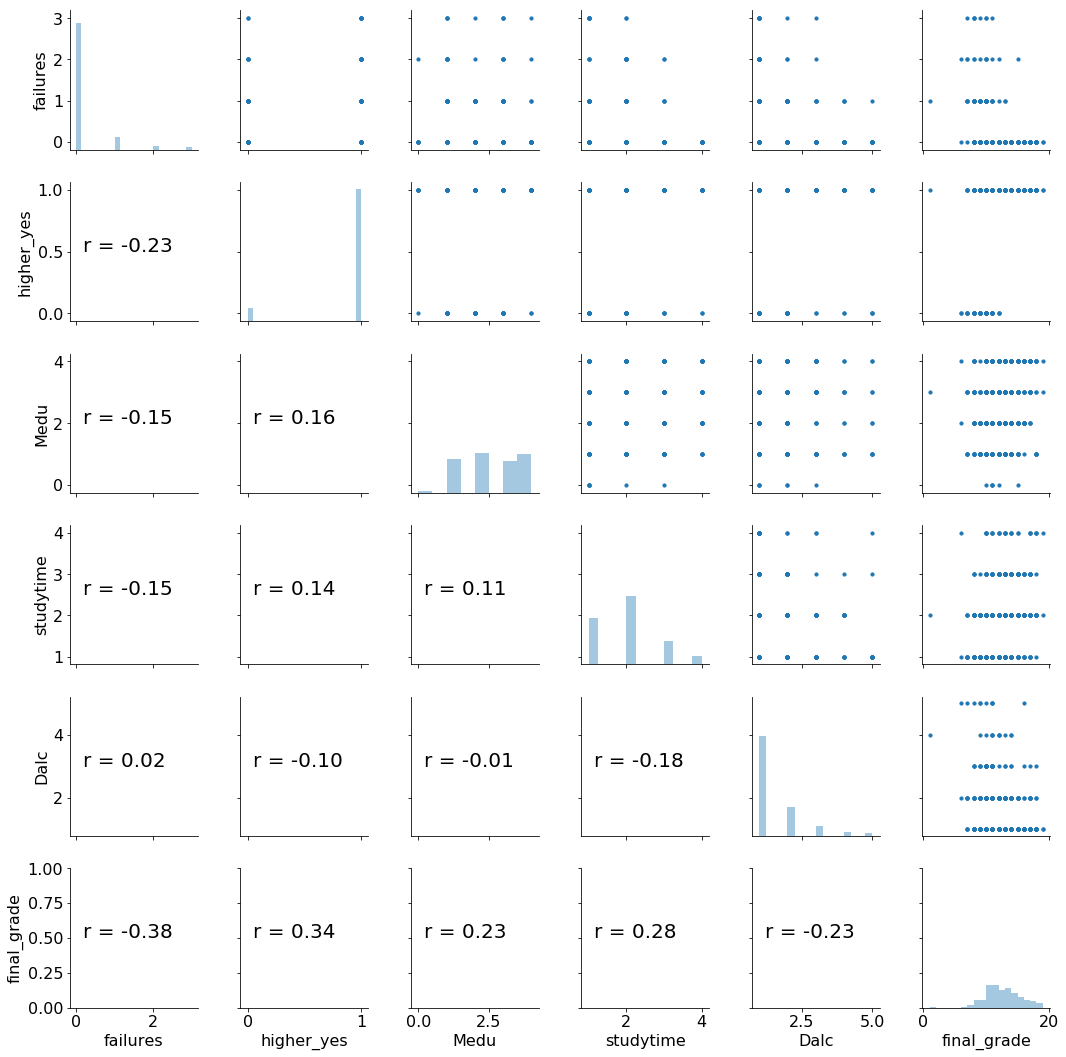

In [20]:
X_train_labels = X_train_math.copy()
X_train_labels['final_grade'] = list(y_train_math)

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .5), xycoords=ax.transAxes,
               size = 20)

# Pair grid set up
g = sns.PairGrid(X_train_labels, palette=["red"])

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10)

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False)

# Correlation coefficients on the lower triangle
g.map_lower(corrfunc);

# Evaluate Standard Machine Learning Models for a Benchmark

We can try several standard machine learning models to compare against the final model from Bayesian Linear Regression. We will use the following models:

1. Standard Linear Regression
2. Elastic Net Linear Regression with an L1 ratio of 0.5
3. A Random Forest Regression with 50 trees
4. An Extra Trees Regression with 50 trees
5. Support Vector Machine Regressor with rbf kernel, a degree of 3, a C penalty of 1, and auto for gamma
6. Gradient Boosting Regressor with 20 trees

The overall baseline will be guessing the median grade of the training final scores as the final score for all testing examples.

## Metrics

We will use two metrics to evaluate models:

* Root Mean Squared Error (RMSE): the square root of the average squared error, has the same units as the target variable (grade)
* Median Absolute Percentage Error (MAPE): the fractional error of the estimate, multiply the MAPE by 100 and subtract from 100 to get an estimate of accuraccy. 

These metrics will be used to compare the various models for performance. This is no one single best metric for regression and that is why we use two different measures.

In [21]:
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['rmse', 'mape'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mape = np.median(np.divide(abs(predictions - y_test), y_test, where= y_test!=0))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.ix[model_name, :] = [rmse, mape]
    
    # Median Value Baseline Metrics
    baseline_mse = np.mean((np.median(y_train_math) - y_test) ** 2)
    baseline_rmse = np.sqrt(baseline_mse)
    baseline_mape = np.median(np.divide(abs(np.mean(y_train) - y_test), y_test, where= y_test!=0))
    
    results.ix['Baseline', :] = [baseline_rmse, baseline_mape]
    
    return results
        

In [22]:
math_results = evaluate(X_train_math, X_test_math, y_train_math, y_test_math)

## Machine Learning Model Results

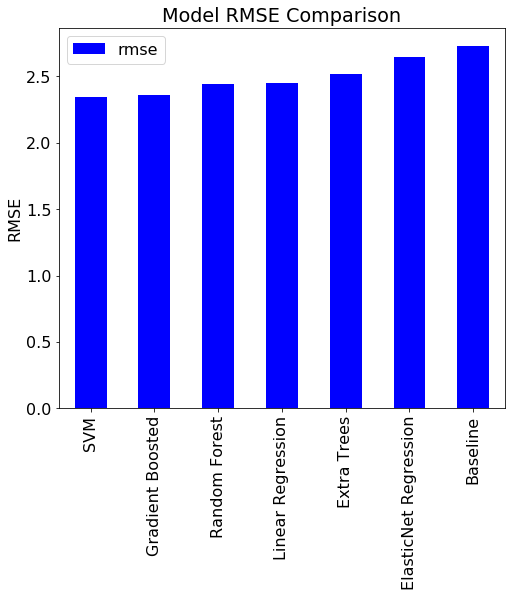

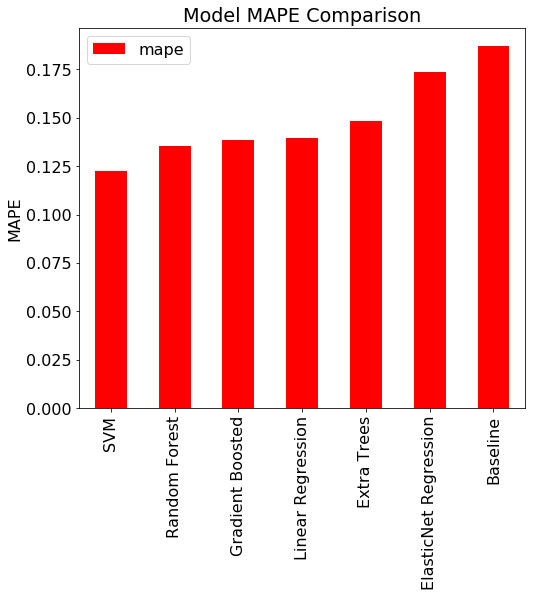

In [23]:
figsize(8, 7)
# Root mean squared error
ax = math_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b')
plt.title('Model RMSE Comparison'); plt.ylabel('RMSE');

# Median absolute percentage error
math_results.sort_values('mape', ascending = True).plot.bar(y = 'mape', color = 'r')
plt.title('Model MAPE Comparison'); plt.ylabel('MAPE');

From the metrics, we can see that the Support Vector Machine Regression performs the best followed by the tree base learning methods. All methods perform better than the median baseline. I did not do any hyperparameter tuning with these models and performance could likely be improved using optimization with cross validation. We can use these scores as a reasonable baseline for comparison.

# Implementing Bayesian Linear Regression

We will be using the `GLM.from_formula` function in PyMC3 which means we need to create a formula relating the explanatory variables (the features) to the response (the final grade). The `GLM.from_formula` function call uses the R formula syntax which is shown below. When the model performs inference, it will draw samples from the posterior for each of the variables in the formula, along with an intercept and a variance.

In [24]:
X_train_math['y'] = list(y_train_math)
formula = 'y ~ ' + ' + '.join(['%s' % variable for variable in X_train_math.columns[:-1]])

### Formula for Linear Regression

In [25]:
formula

'y ~ failures + higher_yes + Medu + studytime + Dalc'

Now, we can create the model using PyMC3 and perform Markov Chain Monte Carlo to sample from the posterior. The function `GLM.from_formula` parses the formula string, adds a random variable for each regressor and a likelihood for each random variable which by default is a normal distribution. The function then initializes the parameters (weights, $\beta$) to sensible starting points using a frequentists estimate provided by statsmodels. 

After we perform the sampling, we can examine the varibles from the trace to make predictions and examine the weights of different variables. This model is called the normal model because it assumes the features are drawn from normal distributions, an assumption we will alter in a later iteration. 

In [26]:
with pm.Model() as normal_model:
    # Error term
    pm.GLM.from_formula(formula, X_train_math)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=NDRAWS, tune = 500, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, Dalc, studytime, Medu, higher_yes, failures, Intercept]
100%|██████████| 2500/2500 [00:19<00:00, 130.14it/s]
The acceptance probability does not match the target. It is 0.8941821997505642, but should be close to 0.8. Try to increase the number of tuning steps.


This model uses relies on PyMC3 for auto-assignment of the sampler. In this case, the model uses the [No-UTurn Sampling method (NUTS)](http://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf) which is a special case of [Hamiltonian Monte Carlo (HMC))](https://arxiv.org/abs/1701.02434) sampling. Hamiltonian Monte Carlo methods avoid the common random walk behavior of Markov Chain Monte Carlo algorithms by taking steps informed by the first-order gradient. NUTS automatically stops when it begins to double back and retrace steps (No-UTurn) and is generally more efficient than Hamiltonian Monte Carlo which is in turn more efficient than Markov Chain Monte Carlo. HMC converges more quickly than standard MCMC because it avoids the random walk behavior and is an informed sampling method.

# Examine Bayesian Model Results

Rather than provide us with a single estimate for each of the weights, Markov Chain Monte Carlo sampling gives us a distribution of samples for every model parameter. There are many tools available in PyMC3 for examining the results of a model run. For a start, we can use `pm.traceplot` to examine the distribution of every variable sampled by the model. 

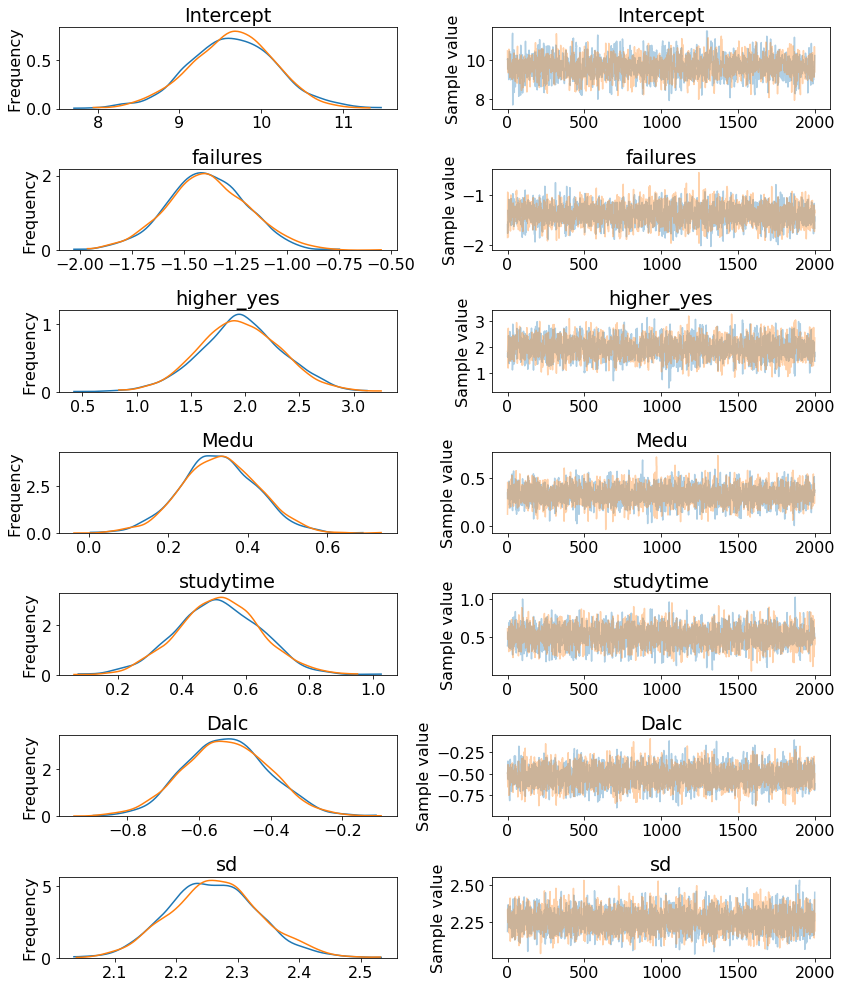

In [27]:
pm.traceplot(normal_trace);

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs. 

Another method built into PyMC3 for examinig trace results is the forestplot which shows the distribution of each sampled parameter. This allows us to see the uncertainty in each sample. The forestplot is easily constructed from the trace using `pm.forestplot`.

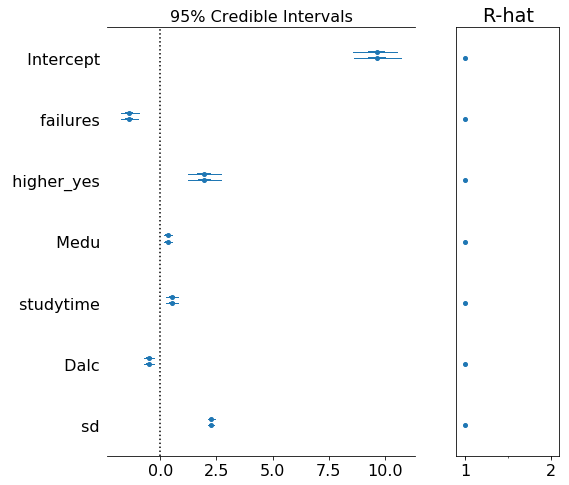

In [28]:
pm.forestplot(normal_trace);

From the forest plot we can see the most likely value of the parameter (the dot) as well as the 95% confidence interval for the parameter. The `intercept` and `higher_yes` have larger uncertainty compared to the other variables. When we go to make predictions, we can estimate a single number using the most likely value and a range of possible values using all of the samples. 

A third method PyMC3 offers for examining the trace of a sampling run is the density plot. This shows the kernel density estimate for each parameter (or the histogram for discrete variables). This again allows us to visualize the distribution of samples.

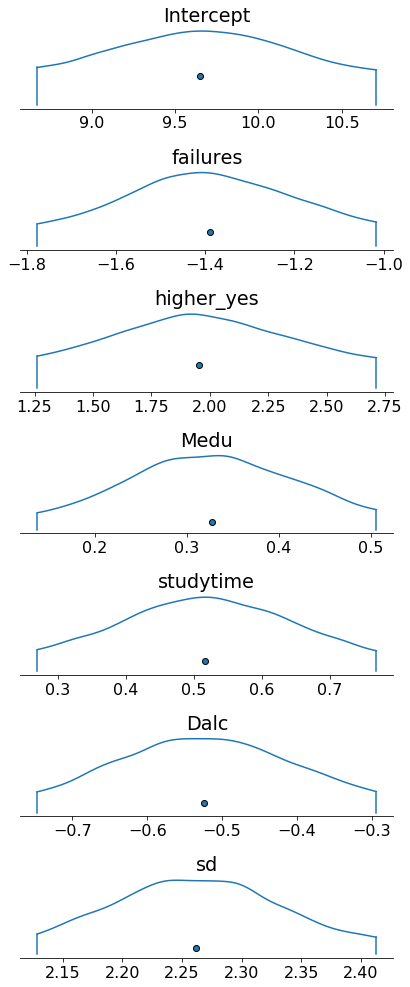

In [29]:
pm.densityplot(normal_trace);

In [30]:
for variable in normal_trace.varnames:
    print('Variable: {:10} Median weight in model: {:.4f}'.format(variable, 
                                                                np.median(normal_trace[variable])))

Variable: Intercept  Median weight in model: 9.6527
Variable: failures   Median weight in model: -1.3932
Variable: higher_yes Median weight in model: 1.9463
Variable: Medu       Median weight in model: 0.3270
Variable: studytime  Median weight in model: 0.5152
Variable: Dalc       Median weight in model: -0.5260
Variable: sd_log__   Median weight in model: 0.8157
Variable: sd         Median weight in model: 2.2607


## Interpretations of Weights

Based on the sign and location of the weights, we can make the following inferences regarding the features in our dataset:

* Previous class failures are negatively related to the students final grade
* Higher education ambitions are positively related to the students grade
* The mother's education level is positively related to the students final grade
* Studying time per week is positively related to the students final grade
* Alcohol consumption during the week is negatively related to the students final grade

# Evaluate Bayesian Model Using Most Likely Values for Weights

Now, we can make predictions for students outcomes using the trace samples. To come up with a single estimate, we take the mean of all the parameter samples as the single value of the parameter. 

In [31]:
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns
    X_test = X_test.ix[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.ix[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
    
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    rmse = np.sqrt(mean_squared_error(results['estimate'], actual))
    mape = np.median(abs(errors) / actual)
    
    print('Model RMSE: {:.4f}\nModel MAPE: {:.4f}'.format(rmse, mape))

    # Plot the observations and predictions
    figsize(10, 10)
    plt.scatter(results.index, actual, label = 'Observed', color = 'blue')
    plt.scatter(results.index, results['estimate'], label = 'Estimate', color = 'red')
    plt.legend(prop={'size': 14}); plt.xlabel('Index'); plt.ylabel('Grade');
    plt.title('Observed and Estimated Values')
    plt.show()
    
    # Add the results to the comparison dataframe
    model_results.ix['Bayesian LM', :] = [rmse, mape]
    
    
    # Plot root mean squared error of all models
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(1, 2, 1)
    model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
    plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')

    # Plot median absolute percentage error of all models
    ax = plt.subplot(1, 2, 2)
    model_results.sort_values('mape', ascending = True).plot.bar(y = 'mape', color = 'r', ax = ax)
    plt.title('Model MAPE Comparison'); plt.ylabel('MAPE'); 
    plt.show();
    
    return results

Model RMSE: 2.4474
Model MAPE: 0.1393


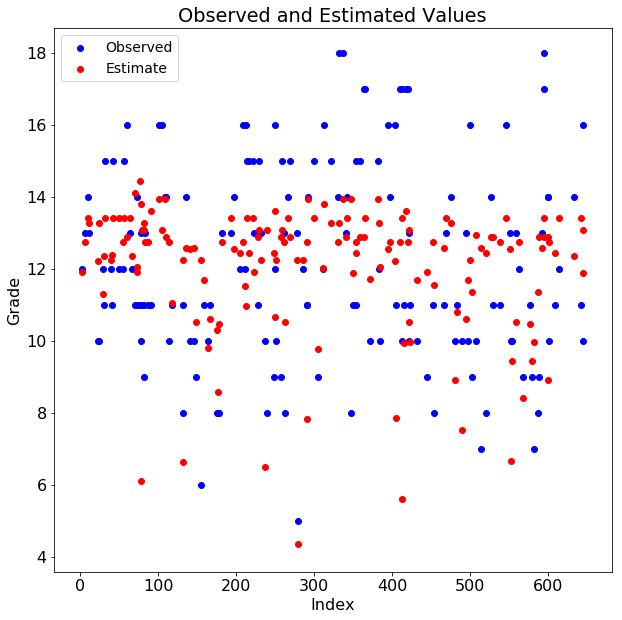

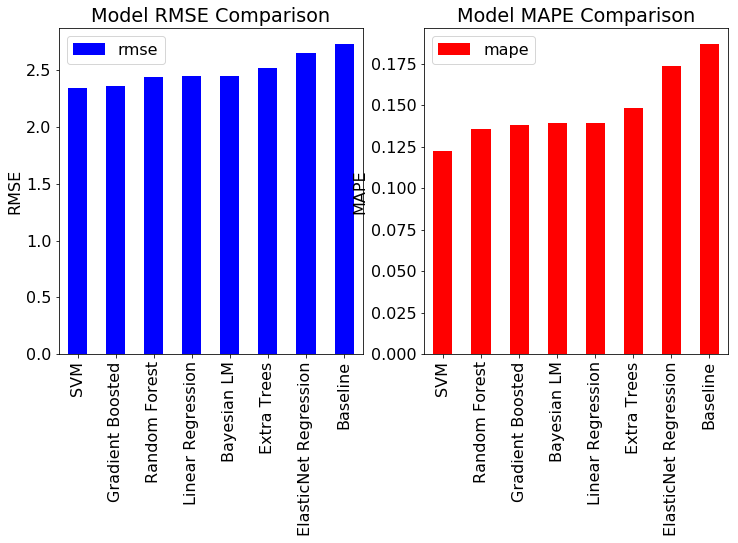

In [32]:
results = evaluate_trace(normal_trace, X_train_math, X_test_math, y_train_math, y_test_math, math_results)

Our first attempt at creating a Bayesian Generalized Linear Model does not do that well in comparison to other models. To improve the model, we could draw more samples or try selecting additional features. However, there are other benefits to a Bayesian model such as uncertainty estimates that might make the tradeoff of slightly lower performance acceptable.


# Query Model

We can now make predictions from the model by passing in a new observation. As the trace contains every sample drawn from the posterior for every weight, we can calculate an entire range of estimates instead of a single number. This shows that there is uncertainty in our estimate. 

In [33]:
def query_model(trace, new_observation):
     # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    
    weights = np.array(var_weights.ix[:, observation.columns])
    estimates = np.dot(weights, np.array(new_observation).reshape(6, 1))

    plt.figure(figsize(8, 8))
    sns.distplot(estimates[:, 0], hist = True, kde = True,
                 hist_kws = {'edgecolor': 'k', 'color': 'navy'})
    plt.title('Density Plot for New Observation');
    plt.xlabel('Estimate'); plt.ylabel('Density');
    
    print('Average Estimate = %0.4f' % np.median(estimates))
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

Average Estimate = 13.9301
5% Estimate = 13.5880    95% Estimate = 14.2889


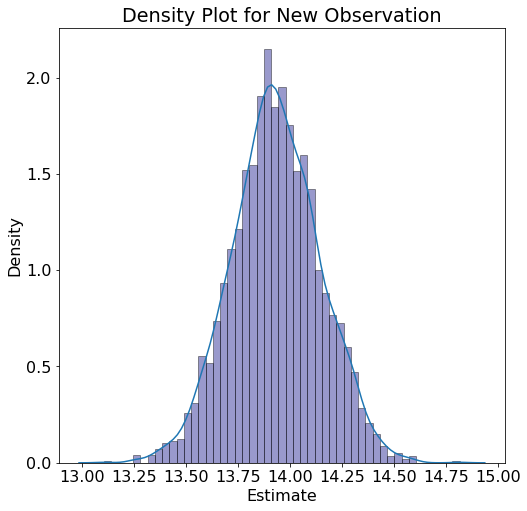

In [34]:
observation = pd.DataFrame({'Intercept': 1, 'Medu': 4, 'failures': 0, 
                            'higher_yes': 1, 'studytime': 3,
                            'Dalc': 1, }, index = [0])
query_model(normal_trace, observation)

Average Estimate = 9.4627
5% Estimate = 8.8266    95% Estimate = 10.1013


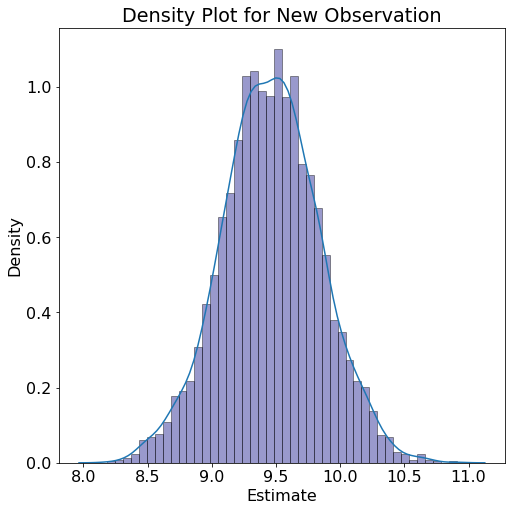

In [35]:
observation = pd.DataFrame({'Intercept': 1, 'Medu': 2, 'failures': 2, 
                            'higher_yes': 1, 'studytime': 2,
                            'Dalc': 2, }, index = [0])
query_model(normal_trace, observation)

The model estimations seem reasonable and are in line with our intuitions about what influences grades. Moreover, the model predictions take on a range of values which reflects the uncertainty in any real-world prediction. The benefit of Bayesian Inference is that we can show that uncertainty by displaying a range of possible answers instead of a single value. 

# Student T Prior Distribution

In order to make our model more robust to outliers, we can use a different distribution, other than the default of normal, for the prior for the parameters. We can try the Student T Distribution, which has more weight in the tails, meaning the values further from the mean have a higher probability than in a Normal Distribution. This distribution should limit the effect of outliers on the model.

<h4>  Normal Vs Student T Distribution </h4>
![](images/normal_t.png)

To change the prior distribution in our PyMC3 model, we only have to make a family and pass in to the `pm.GLM.from_formula` function call. The function then knows to sample from the T distribution rather than from the normal for all the samples. 

In [36]:
formula

'y ~ failures + higher_yes + Medu + studytime + Dalc'

In [37]:
X_train_math['y'] = list(y_train_math)

with pm.Model() as t_model:
    family = pm.glm.families.StudentT()
    pm.GLM.from_formula(formula, 
                        data = X_train_math, family = family)
    
    # Sample from the posterior 
    t_trace = pm.sample(draws=NDRAWS, tune=500, njobs = -1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam_log__, Dalc, studytime, Medu, higher_yes, failures, Intercept]
100%|██████████| 2500/2500 [00:17<00:00, 145.25it/s]
The acceptance probability does not match the target. It is 0.8834000488954877, but should be close to 0.8. Try to increase the number of tuning steps.


## Examine Samples from New Model

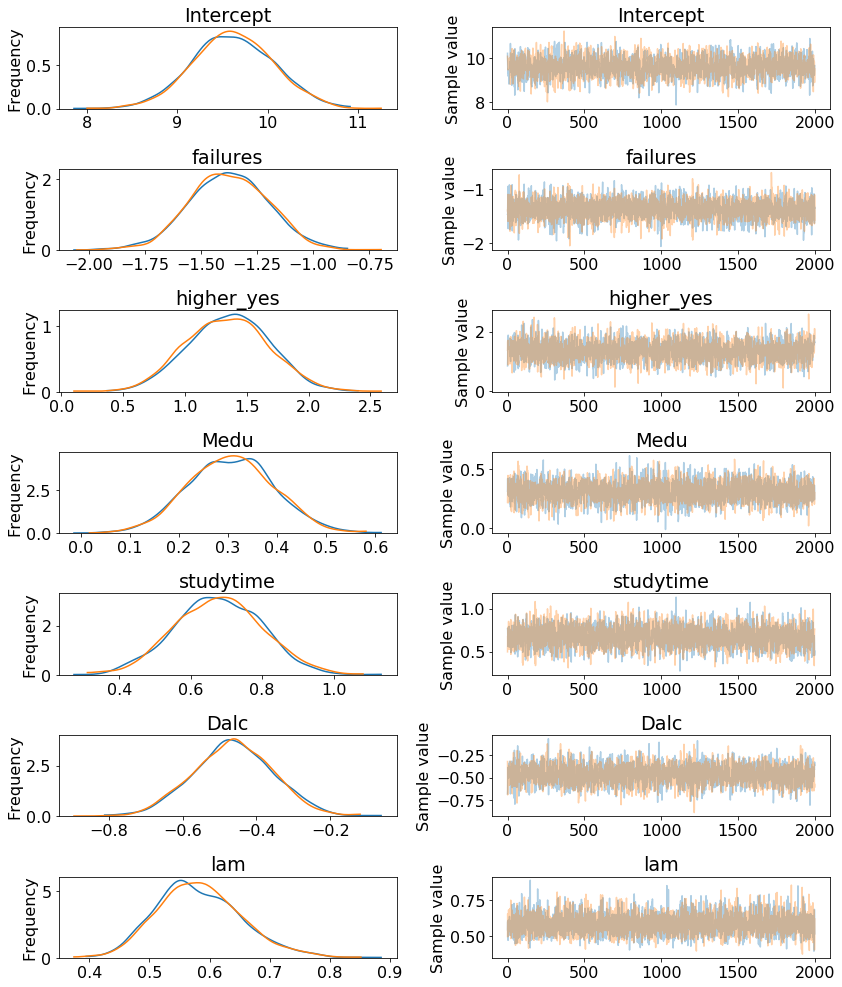

In [38]:
pm.traceplot(t_trace);

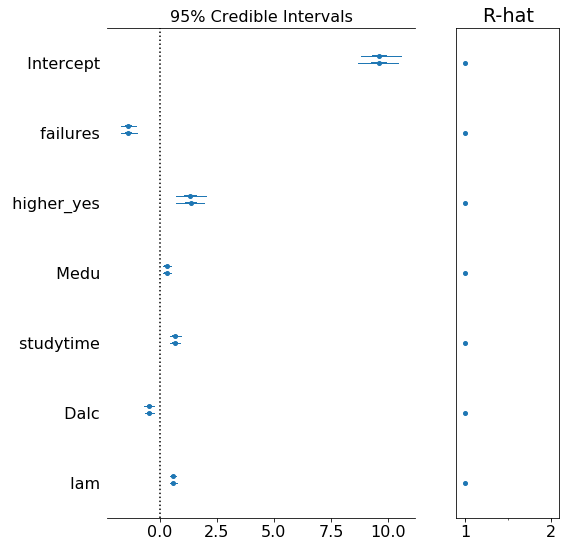

In [39]:
pm.forestplot(t_trace);

The distributions again show the spread of each parameter sampled during the model run. The `intercept` and `higher_yes` variables have the highest amount of uncertainty as was observed for the model using a normal prior distribution.

# Evaluate the New Model

Model RMSE: 2.4486
Model MAPE: 0.1330


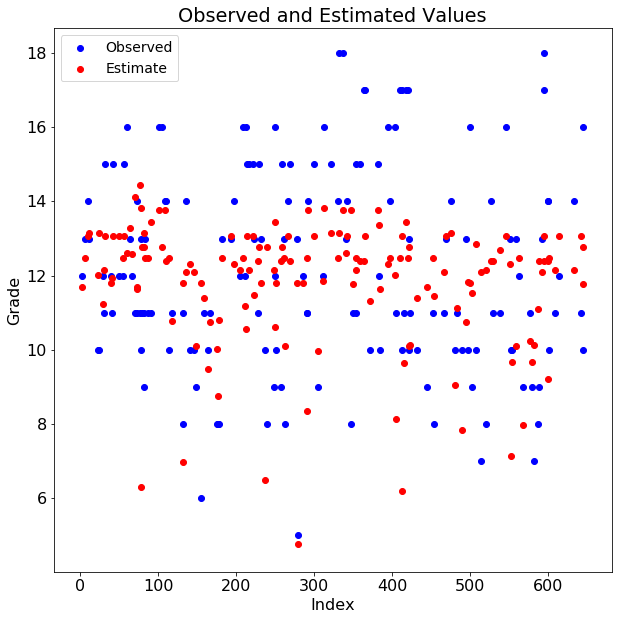

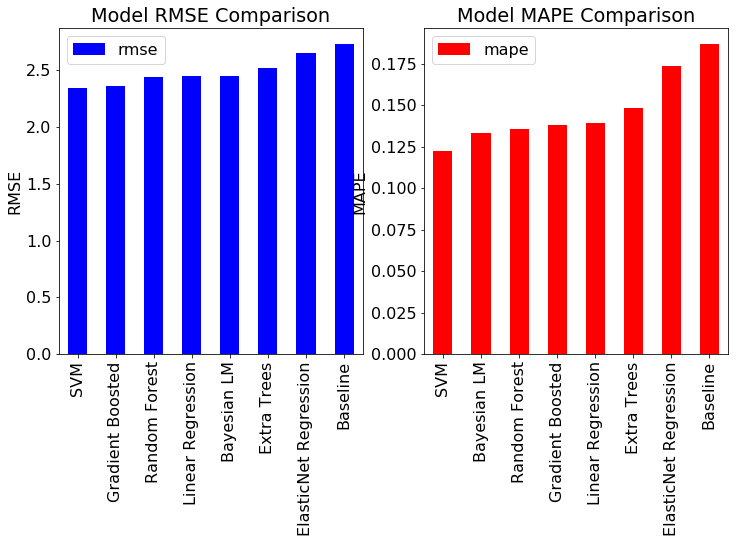

In [40]:
results = evaluate_trace(t_trace, X_train_math, X_test_math, y_train_math, y_test_math, math_results)

The t-distribution metrics are nearly identical to those from the normal distribution. As the number of samples/datapoints increases, the prior has less impact on the final results because the likelihoods come to dominate the parameters drawn from the posterior. We can do the same querying of the new model to view the predictions for observations from a new student. Again, we will plot the entire range of predicted values to show our uncertainty in the prediction.

## Query T-Distribution Model

Average Estimate = 13.7615
5% Estimate = 13.4020    95% Estimate = 14.1107


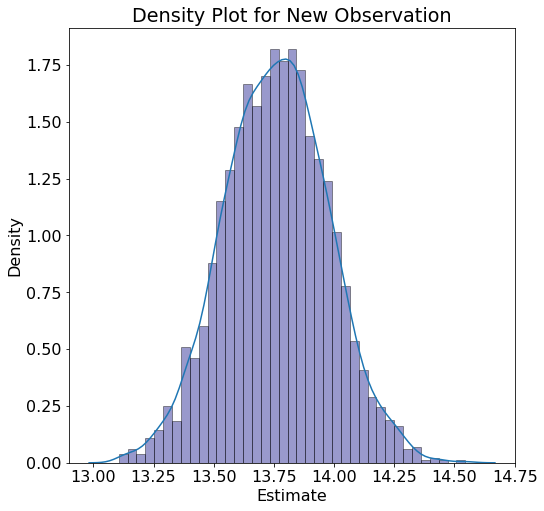

In [41]:
observation = pd.DataFrame({'Intercept': 1, 'Medu': 4, 'failures': 0, 
                            'higher_yes': 1, 'studytime': 3,
                            'Dalc': 1, }, index = [0])
query_model(t_trace, observation)

Average Estimate = 9.2458
5% Estimate = 8.6956    95% Estimate = 9.8221


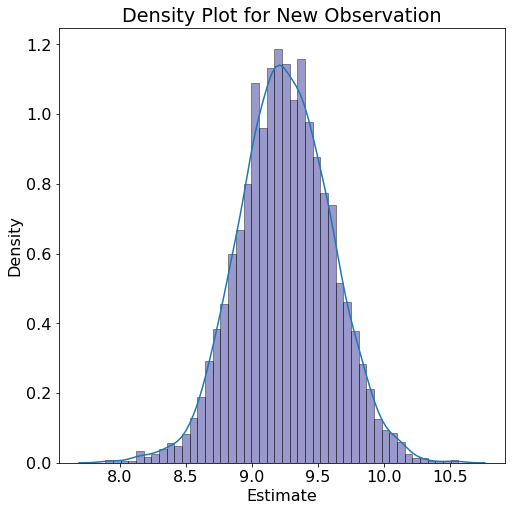

In [42]:
observation = pd.DataFrame({'Intercept': 1, 'Medu': 2, 'failures': 2, 
                            'higher_yes': 1, 'studytime': 2,
                            'Dalc': 2, }, index = [0])
query_model(t_trace, observation)

There is some variation between the t-distribution estimates and those from the normal distribution as prior model. We can try other types of prior distributions as well, but for now I will halt with the normal and the t-distribution. Choosing appropriate priors is one of the hardest aspect of Bayesian Modeling, but we can get around that by having more data. As the amount of data the model learns from increases, the prior has less of an effect because each time the posterior is updated based on the new data. Essentially machine learning models perform inference with no priors, basing the final model entirely on the data. In the case of limited samples, Bayesian Inference can be a better method for building models because it provides a reasonable estimate in situations with few data points (as long as the prior is reasonable).

# Conclusions

In this notebook we looked at using Bayesian Linear Regression to predict student performance based on five factors. Rather than specify probabilities for the Bayesian network which is basically impossible for continuous variables, we framed the problem as a machine learning task. In addition to the standard machine learning models that learn from observations, we also used Bayesian Linear Regression to create a model mapping the features (student characteristics) to the targets (final grade). The advantages of Bayesian Linear Regression are that if we use sensible priors, we can still get a decent estimate with few samples, and the final weights are not a single number, but a distribution componsed of every sample drawn during the sampling run. We can then make predictions using all the sampled weights to form a distribution of expected values rather than a single answer. 

The Bayesian  Linear Regression did not perform as well as the other methods in terms of the two metrics we choose. This might not be the ideal case for a Bayesian inference approach but we saw that Bayesian Linear Regression produced intuitive estimates for the model weights and gave predictions for new students that align with our expectations for the factors influencing student performance. To summarize, although Bayesian Linear Regression did not outperform the standard machine learning methods, it gave us a chance to learn another tool for use in evaluation and making sense of data. There are likely situations in which Bayesian inference is better suited than standard machine learning, and it is best to be prepared for those situations when we find them. 